# Notes on Explainable Boosting Machines

Nathan A. Mahynski

Microsoft's [interpretML](https://interpret.ml/docs/ebm.html) library as documentation for EBMs.

[Kaggle](https://www.kaggle.com/code/parulpandey/explainable-boosting-machines-for-tabular-data/notebook) has a nice example, too.

tl;dr

---

An Explainable Boosting Machine (EBM) is a tree-based, cyclic gradient boosting Generalized Additive Model with automatic interaction detection.

The GAM has the general form:

$g \left( E[y] \right) = \beta_0 + \sum f_j(x_j)$

where $g$ is a link function that adapts it to classification or regression problems as needed (e.g., logit vs. identity).

First, EBM learns each feature function $f_j$ using modern machine learning techniques such as bagging and gradient boosting. The boosting procedure is carefully restricted to train on one feature at a time in round-robin fashion using a very low learning rate so that feature order does not matter. It round-robin cycles through features to mitigate the effects of co-linearity and to learn the best feature function $f_j$ for each feature to show how each feature contributes to the model’s prediction for the problem. 

Second, EBM can automatically detect and include pairwise interaction terms of the form:

$g \left( E[y] \right) = \beta_0 + \sum f_i(x_i) + \sum f_{i,j}(x_ix_j)$

EBMs are **slow to train** but **fast to run** at prediction time.

Notes

---

Note that show(explainer) seems to only work one time for a session on Colab.  Retart the session and execute a new explanation to change this.

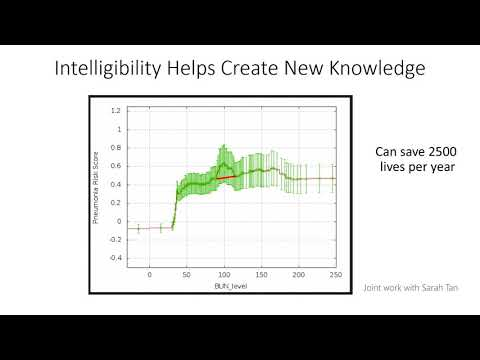

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('MREiHgHgl0k', width=1000, height=500)

In [ ]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
  from google.colab import drive
  drive.mount('/gdrive')
  root_dir = '/gdrive/MyDrive/Mayan EDMS/Research/Machine Learning/Colab Notebook Examples/ebm'
else:
  import os
  root_dir = os.getcwd()

Mounted at /gdrive


In [ ]:
!pip install interpret
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import interpret
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

import pandas as pd
from sklearn.model_selection import train_test_split
from interpret import show

In [ ]:
import watermark
%load_ext watermark

%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.34.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

watermark: 2.3.1
interpret: 0.2.7
pandas   : 1.3.5



# Classifier

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
df = df.sample(frac=0.05)
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]

In [ ]:
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

ebm = ExplainableBoostingClassifier(random_state=seed)
_ = ebm.fit(X_train, y_train)

In [ ]:
ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
ebm_local = ebm.explain_local(X_test[:1], y_test[:1])
show(ebm_local)

Output hidden; open in https://colab.research.google.com to view.

# Regression

## Not a great fit

In [ ]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
df['progression'] = diabetes.target

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor

seed = 1
X_train, X_test, y_train, y_test = train_test_split(df[diabetes.feature_names], df['progression'], test_size=0.20, random_state=seed)

ebm = ExplainableBoostingRegressor(random_state=seed, learning_rate=0.001)
_ = ebm.fit(X_train, y_train)

In [ ]:
ebm.score(X_test, y_test)

0.37065329414253156

Text(0, 0.5, 'y_pred')

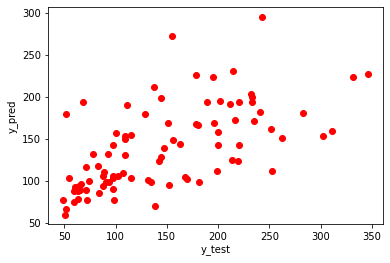

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test, ebm.predict(X_test), 'ro')
plt.xlabel('y_test') 
plt.ylabel('y_pred')

In [ ]:
ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
ebm_local = ebm.explain_local(X_test[:1], y_test[:1])
show(ebm_local)

## A better fit

In [ ]:
from sklearn.datasets import load_boston

boston = load_boston()

df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df['price'] = boston.target

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor

seed = 1
X_train, X_test, y_train, y_test = train_test_split(df[boston.feature_names], df['price'], test_size=0.20, random_state=seed)

ebm = ExplainableBoostingRegressor(random_state=seed, learning_rate=0.001)
_ = ebm.fit(X_train, y_train)

In [ ]:
ebm.score(X_test, y_test)

0.8517030752933188

Text(0, 0.5, 'y_pred')

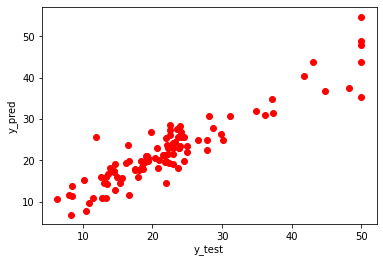

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(y_test, ebm.predict(X_test), 'ro')
plt.xlabel('y_test') 
plt.ylabel('y_pred')

In [ ]:
ebm_global = ebm.explain_global()
show(ebm_global)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ebm_local = ebm.explain_local(X_test[:1], y_test[:1])
show(ebm_local)